In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, ArrayType, StringType

In [2]:
spark = SparkSession.builder.appName("IMDb Crew Data Processing").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/24 12:59:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
crew_schema = StructType([
    StructField("tconst", StringType(), True),
    StructField("directors", StringType(), True),
    StructField("writers", StringType(), True)
    ])

In [4]:
crew_df = spark.read.csv("../data/title.crew.tsv", header=True, schema=crew_schema, sep="\t")

In [5]:
crew_df.printSchema()
crew_df.head(5)

root
 |-- tconst: string (nullable = true)
 |-- directors: string (nullable = true)
 |-- writers: string (nullable = true)


[Row(tconst='tt0000001', directors='nm0005690', writers='\\N'),
 Row(tconst='tt0000002', directors='nm0721526', writers='\\N'),
 Row(tconst='tt0000003', directors='nm0721526', writers='nm0721526'),
 Row(tconst='tt0000004', directors='nm0721526', writers='\\N'),
 Row(tconst='tt0000005', directors='nm0005690', writers='\\N')]

In [6]:
string_cols = [field.name for field in crew_df.schema.fields if isinstance(field.dataType, (StringType, ArrayType))]
print(f"String columns: {string_cols}")

String columns: ['tconst', 'directors', 'writers']


In [7]:
print("Number of rows:")
crew_df.count()

Number of rows:


11536090

In [8]:
print("Number of columns:")
len(crew_df.columns)

Number of columns:


3

In [9]:
crew_df = crew_df.replace('\\N', None)

In [13]:
from pyspark.sql.functions import count
duplicates_df = crew_df.groupBy("tconst").agg(count("*").alias("count")).filter("count > 1")
duplicates_df.show(truncate=False)

[Stage 10:====>                                                   (1 + 11) / 12]

+------+-----+
|tconst|count|
+------+-----+
+------+-----+


In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, when, count, explode, split, expr, sum as spark_sum

In [ ]:
!pip install pandas matplotlib

In [19]:
# null_counts = crew_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in crew_df.columns])
# null_counts.show()

null_counts = crew_df.select(
    count(when((col("directors").isNull()) & col("writers").isNotNull(), 1)).alias("only_directors_None"),
    count(when((col("writers").isNull()) & col("directors").isNotNull(), 1)).alias("only_writers_None"),
    count(when((col("directors").isNull()) & (col("writers").isNull()), 1)).alias("both_None"),
    count(when(col("directors").isNotNull() & col("writers").isNotNull(), 1)).alias("both_not_None")
)

null_counts.show()

[Stage 44:=================>                                      (5 + 11) / 16]

+-------------------+-----------------+---------+-------------+
|only_directors_None|only_writers_None|both_None|both_not_None|
+-------------------+-----------------+---------+-------------+
|             845573|          1517840|  4160505|      5012172|
+-------------------+-----------------+---------+-------------+


In [12]:
crew_df.select("directors", "writers").show(15, truncate=False)

+-------------------+---------+
|directors          |writers  |
+-------------------+---------+
|nm0005690          |null     |
|nm0721526          |null     |
|nm0721526          |nm0721526|
|nm0721526          |null     |
|nm0005690          |null     |
|nm0005690          |null     |
|nm0005690,nm0374658|null     |
|nm0005690          |null     |
|nm0085156          |nm0085156|
|nm0525910          |null     |
|nm0804434          |null     |
|nm0525908,nm0525910|null     |
|nm0525910          |null     |
|nm0525910          |null     |
|nm0721526          |nm0721526|
+-------------------+---------+


In [25]:
unique_directors_count = (
    crew_df.withColumn("director", explode(split(col("directors"), ",")))
    .select("director")
    .na.drop()
    .distinct()
    .count()
)

unique_writers_count = (
    crew_df.withColumn("writer", explode(split(col("writers"), ",")))
    .select("writer")
    .na.drop()
    .distinct()
    .count()
)

print(f"Number of rows: {crew_df.count()}")
print(f"Unique Directors: {unique_directors_count}, {unique_directors_count / crew_df.count() * 100}%")
print(f"Unique Writers: {unique_writers_count}, {unique_writers_count / crew_df.count() * 100}%")

Number of rows: 11536090


Unique Directors: 836398, 7.250272839410927%


[Stage 104:===>                                                   (1 + 15) / 16]

Unique Writers: 1067479, 9.253386546048098%


In [26]:
crew_df = crew_df.withColumn("directors_array", split(col("directors"), ","))
crew_df = crew_df.withColumn("writers_array", split(col("writers"), ","))

same_count = crew_df.filter(
    expr("size(array_except(directors_array, writers_array)) = 0 AND size(array_except(writers_array, directors_array)) = 0")
).count()

print(f"Number of rows: {crew_df.count()}")
print(f"Rows where writers and directors are the same: {same_count}, {same_count / crew_df.count() * 100}%")

Number of rows: 11536090


[Stage 113:===================================================>   (15 + 1) / 16]

Rows where writers and directors are the same: 1103760, 9.567886519609331%


In [39]:
def plot_top_entities(df, title, x_label):
    plt.figure(figsize=(12, 8))
    plt.barh(df[x_label], df["count"], color="skyblue")
    plt.xlabel("Mentions")
    plt.ylabel(x_label)
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

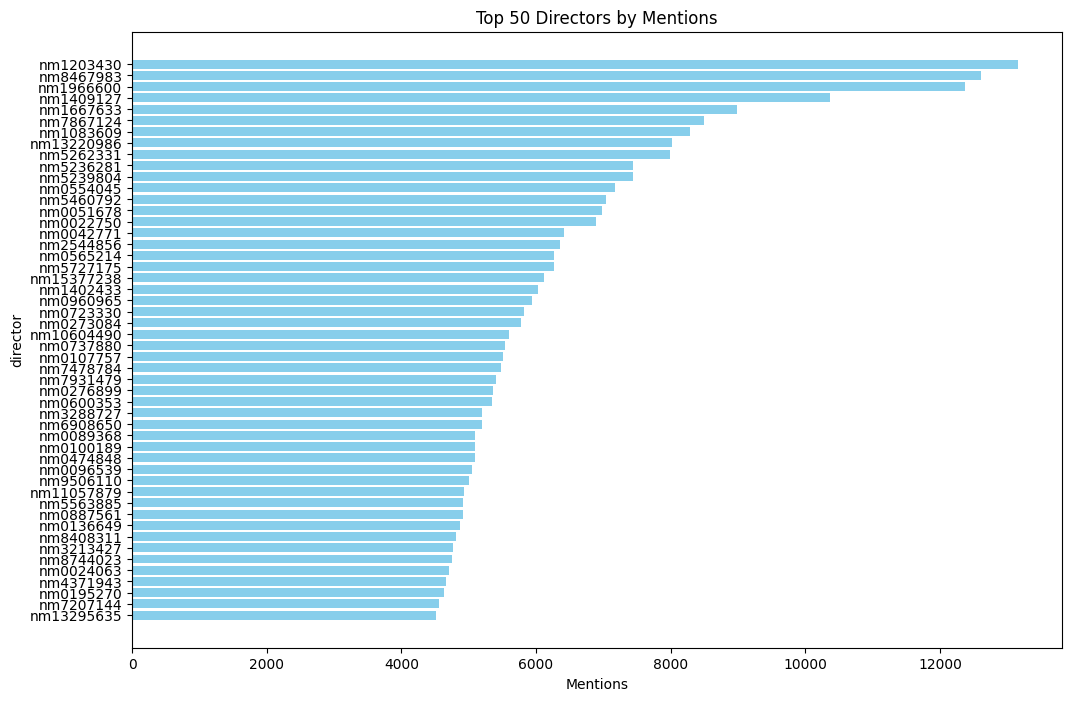

In [45]:
crew_df = crew_df.withColumn("directors", split(col("directors"), ","))
directors_df = crew_df.withColumn("director", explode(col("directors"))).groupBy("director").count()
top_directors = directors_df.orderBy(col("count").desc()).limit(50).toPandas()
plot_top_entities(top_directors, "Top 50 Directors by Mentions", "director")

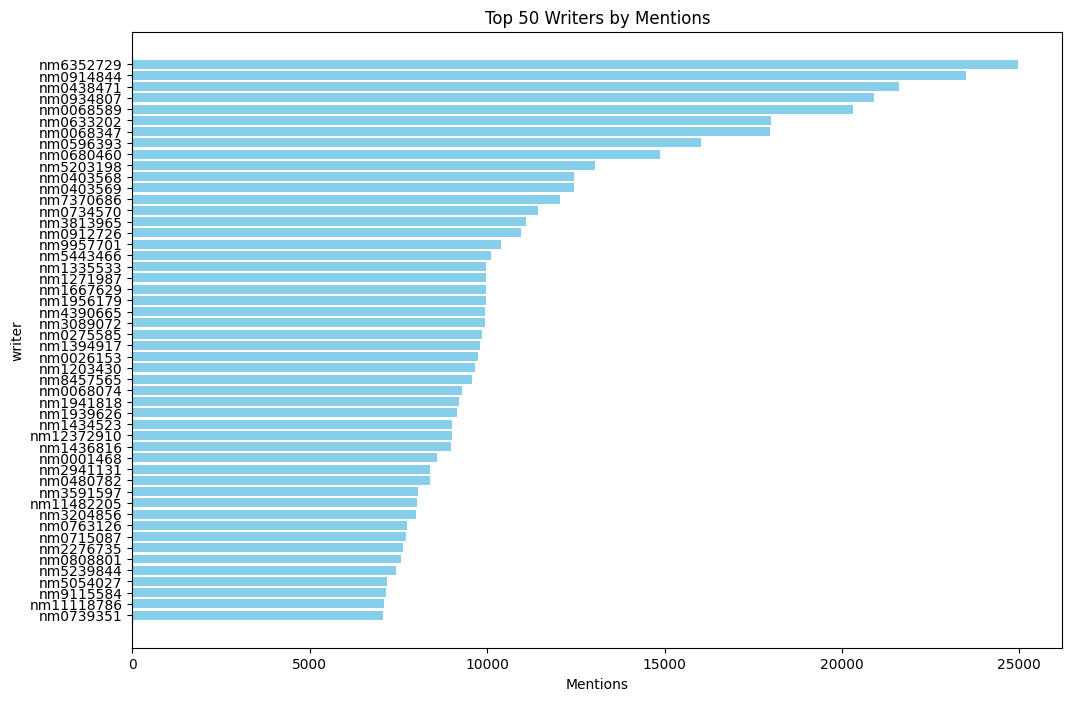

In [43]:
writers_df = crew_df.withColumn("writer", explode(col("writers"))).groupBy("writer").count()
top_writers = writers_df.orderBy(col("count").desc()).limit(50).toPandas()
plot_top_entities(top_writers, "Top 50 Writers by Mentions", "writer")

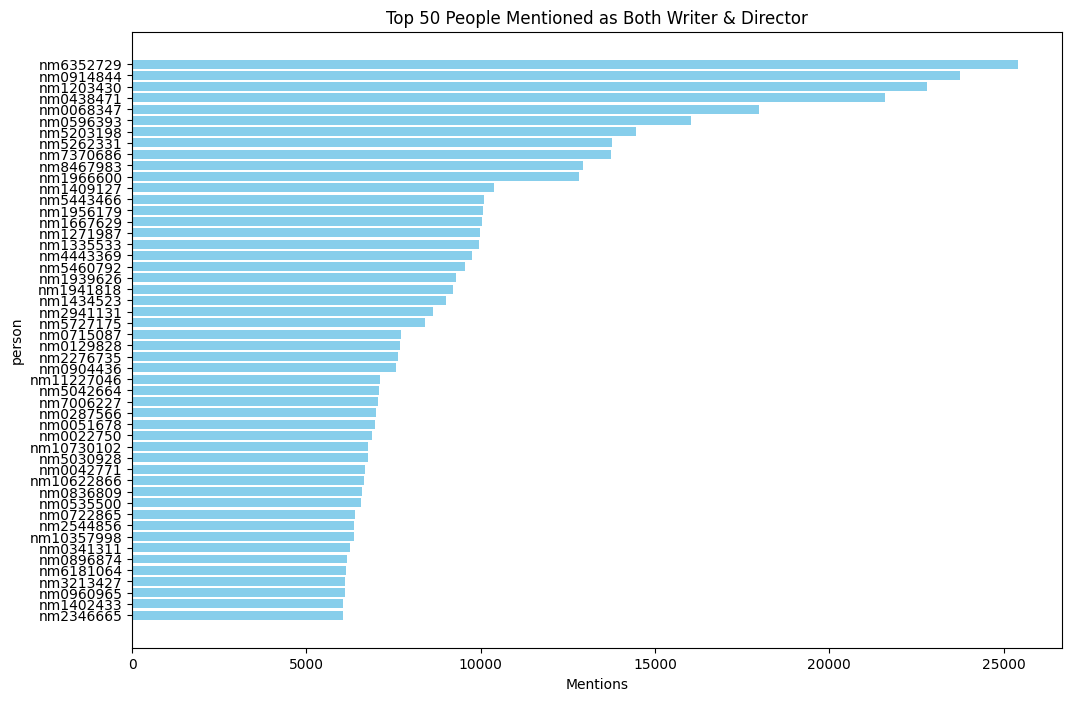

In [52]:
# crew_df = crew_df.withColumn("directors", split(col("directors"), ","))
writers_df = crew_df.withColumn("writer", explode(col("writers"))).groupBy("writer").count().withColumnRenamed("count", "writer_mentions")
directors_df = crew_df.withColumn("director", explode(col("directors"))).groupBy("director").count().withColumnRenamed("count", "director_mentions")

both_roles_df = writers_df.join(directors_df, writers_df.writer == directors_df.director, "inner") \
    .select(col("writer").alias("person"), "writer_mentions", "director_mentions") \
    .withColumn("count", col("writer_mentions") + col("director_mentions"))

top_people = both_roles_df.orderBy(col("count").desc()).limit(50).toPandas()

plot_top_entities(top_people, "Top 50 People Mentioned as Both Writer & Director", "person")

In [54]:
crew_df = spark.read.csv("../data/title.crew.tsv", header=True, schema=crew_schema, sep="\t")
crew_df = crew_df.replace('\\N', None)
crew_df.head(5)

[Row(tconst='tt0000001', directors='nm0005690', writers=None),
 Row(tconst='tt0000002', directors='nm0721526', writers=None),
 Row(tconst='tt0000003', directors='nm0721526', writers='nm0721526'),
 Row(tconst='tt0000004', directors='nm0721526', writers=None),
 Row(tconst='tt0000005', directors='nm0005690', writers=None)]

In [60]:
output_dir = '../data/title.crew.cleaned.tsv'
crew_df.coalesce(1).write.option("header", True).option("sep", "\t").mode("overwrite").csv(output_dir)

print(f"Data saved as {final_output_file}")

Data saved as ../data/title.crew.cleaned.tsv
